Epoch 1/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.0346 - val_loss: 0.0059
Epoch 2/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 3/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 4/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 5/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 8.7172e-04 - val_loss: 0.0026
Epoch 6/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 8.7998e-04 - val_loss: 0.0025
Epoch 7/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 8.7386e-04 - val_loss: 0.0026
Epoch 8/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 8.6761e-04 - val_loss: 0.0027
Epoch 9/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 8.9854e-04 - val_loss: 0.0027
Epoch 10/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 9.9018e-04 - val_loss: 0.0025
Epoch 11/300
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 

/Users/hanzichun/Desktop/Optiver-07/volt/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29256 (\N{CJK UNIFIED IDEOGRAPH-7248}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


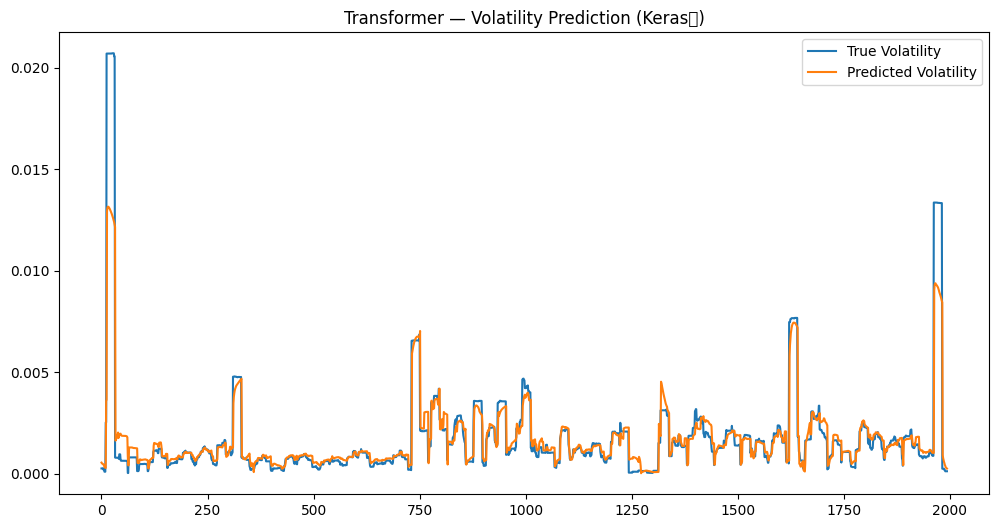

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

np.random.seed(3888)
tf.random.set_seed(3888)

df = pd.read_csv("/Users/hanzichun/Desktop/Optiver-07/Data/S27FE-10K.csv")
volatility = df['realized_volatility'].values.reshape(-1, 1)

scaler = MinMaxScaler()
volatility_scaled = scaler.fit_transform(volatility).flatten()

SEQ_LEN = 30

def create_dataset(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X)[..., np.newaxis], np.array(y)

X, y = create_dataset(volatility_scaled, SEQ_LEN)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

def build_transformer_model(seq_len, input_dim=1, d_model=64, num_heads=4, num_layers=2):
    inputs = layers.Input(shape=(seq_len, input_dim))
    
    x = layers.Dense(d_model)(inputs)
    
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x1, x1)
        x2 = layers.Add()([x, attention_output])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        ffn_output = layers.Dense(d_model * 4, activation='relu')(x3)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([x2, ffn_output])
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    output = layers.Dense(1)(x[:, -1, :])
    model = models.Model(inputs, output)
    return model

model = build_transformer_model(SEQ_LEN)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mse')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=300,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

predictions = model.predict(X_test).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(actuals, label="True Volatility")
plt.plot(predictions, label="Predicted Volatility")
plt.legend()
plt.title("Transformer — Volatility Prediction (Keras版)")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


# Set seeds
np.random.seed(3888)
tf.random.set_seed(3888)

# Custom Transformers
class MakeFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        df = X.copy()
        df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
        df['spread'] = df['ask_price1'] - df['bid_price1']
        df['rel_spread'] = df['spread'] / df['mid_price']
        df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
        df['book_pressure'] = ((df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])) / (df['bid_size1'] + df['bid_size2'] + df['ask_size1'] + df['ask_size2'])
        df['microprice'] = ((df['ask_price1'] * df['bid_size1'] + df['bid_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1']))
        df['normalized_spread'] = df['spread'] / df['mid_price']
        df['OBI_L2'] = ((df['bid_size1'] + df['bid_size2']) / (df['bid_size1'] + df['bid_size2'] + df['ask_size1'] + df['ask_size2']))
        sizes = df[['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']].astype(float).values
        total = sizes.sum(axis=1, keepdims=True)
        p = np.divide(sizes, total, where=total != 0)
        entropy = -np.nansum(np.where(p > 0, p * np.log(p, where=p > 0), 0), axis=1)
        df['LOB_entropy'] = entropy
        df['LOB_entropy_normalized'] = entropy / np.log(4)
        df['log_return'] = df.groupby('time_id')['mid_price'].transform(lambda x: np.log(x / x.shift(1)))
        df['realized_volatility'] = df.groupby('time_id')['log_return'].transform(lambda x: np.sqrt(x.pow(2).rolling(window=30, min_periods=1).sum()))
        df['bipower_var'] = df.groupby('time_id')['log_return'].transform(
            lambda x: (
                x.abs().rolling(2).apply(lambda r: r[0] * r[1], raw=True)
                .rolling(30, min_periods=1).mean()
            )
        )
        df['rolling_integrated_variance'] = df.groupby('time_id')['log_return'].transform(
            lambda x: x.pow(2).rolling(window=30, min_periods=1).sum()
        )
        return df.dropna()

class ReindexFill(BaseEstimator, TransformerMixin):
    def __init__(self, n_seconds=600): self.n_seconds = n_seconds
    def fit(self, X, y=None): return self
    def transform(self, X):
        df = X.copy()
        time_ids = df['time_id'].unique()
        full_index = pd.MultiIndex.from_product([time_ids, range(self.n_seconds)],
                                                names=['time_id', 'seconds_in_bucket'])
        df = df.set_index(['time_id', 'seconds_in_bucket']).reindex(full_index)
        cols_to_fill = [c for c in df.columns if c not in ['time_id', 'seconds_in_bucket']]
        df[cols_to_fill] = df.groupby(level=0)[cols_to_fill].ffill()
        return df.reset_index()

class MapTimeID(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        df = X.copy()
        if 'stock_id' in df.columns:
            mapping = (df.dropna(subset=['stock_id'])
                         .drop_duplicates(subset=['time_id'])
                         .set_index('time_id')['stock_id'])
            df['stock_id'] = df['time_id'].map(mapping)
            df = df.drop('stock_id', axis=1).dropna()
        unique_time_ids = sorted(df['time_id'].unique())
        time_id_map = {old: new for new, old in enumerate(unique_time_ids, start=1)}
        df['time_id'] = df['time_id'].map(time_id_map)
        return df

# Define Pipeline
pipeline = Pipeline([
    ('make_features', MakeFeatures()),
    ('reindex_fill', ReindexFill()),
    ('map_time_id', MapTimeID()),
])


# Load + Transform Data
df_raw = pd.read_csv("/Users/hanzichun/Desktop/Optiver-07/Data/S27FE-10K.csv")
df_processed = pipeline.fit_transform(df_raw)

# Build sequence dataset
SEQ_LEN = 30
df_seq = df_processed[['time_id', 'realized_volatility']].dropna()

vol_seqs = []
for _, group in df_seq.groupby('time_id'):
    vol_series = group['realized_volatility'].values
    if len(vol_series) > SEQ_LEN:
        for i in range(len(vol_series) - SEQ_LEN):
            vol_seqs.append(vol_series[i:i+SEQ_LEN+1])

vol_seqs = np.array(vol_seqs)
X_pipeline, y_pipeline = vol_seqs[:, :-1], vol_seqs[:, -1]


# Normalize sequence
scaler_pipe = MinMaxScaler()
X_pipeline_scaled = scaler_pipe.fit_transform(X_pipeline.flatten().reshape(-1, 1)).reshape(X_pipeline.shape)
y_pipeline_scaled = scaler_pipe.transform(y_pipeline.reshape(-1, 1)).flatten()
X_pipeline_scaled = X_pipeline_scaled[..., np.newaxis]

# Transformer Model (same)
def build_transformer_model(seq_len, input_dim=1, d_model=64, num_heads=4, num_layers=2):
    inputs = layers.Input(shape=(seq_len, input_dim))
    x = layers.Dense(d_model)(inputs)
    for _ in range(num_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x1, x1)
        x2 = layers.Add()([x, attention_output])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        ffn_output = layers.Dense(d_model * 4, activation='relu')(x3)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.Add()([x2, ffn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    output = layers.Dense(1)(x[:, -1, :])
    return models.Model(inputs, output)

# Load trained model
model = build_transformer_model(SEQ_LEN)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# model.load_weights("your_weights_path.h5")  # if you saved it
split = int(len(X_pipeline_scaled) * 0.8)
X_train, X_test = X_pipeline_scaled[:split], X_pipeline_scaled[split:]
y_train, y_test = y_pipeline_scaled[:split], y_pipeline_scaled[split:]

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=300,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Predict & Inverse
y_pred = model.predict(X_test).flatten()
y_pred_inv = scaler_pipe.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_inv = scaler_pipe.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_true_inv, label="True Volatility (Pipeline)")
plt.plot(y_pred_inv, label="Predicted Volatility (Transformer)")
plt.legend()
plt.title("Pipeline-based Volatility Prediction (Transformer)")
plt.show()


Epoch 1/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.3652 - val_loss: 0.0367
Epoch 2/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 0.0012 - val_loss: 0.0182
Epoch 3/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 6.2118e-04 - val_loss: 0.0114
Epoch 4/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 4.7818e-04 - val_loss: 0.0064
Epoch 5/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - loss: 4.1060e-04 - val_loss: 0.0046
Epoch 6/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 5.4431e-04 - val_loss: 0.0053
Epoch 7/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 5.5005e-04 - val_loss: 0.0046
Epoch 8/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 5.1167e-04 - val_loss: 0.0041
Epoch 9/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 5.2857e-04 - val_loss: 0.0040
Epoch 10/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 5.5077e-04 - val_loss: 0.0037
Epoch 11/300
539/539 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 5.1513e-04 - 